In [1]:
using Plots
using NearestNeighbors
using DataStructures
using Ripserer
using CluGen

## Disjoint-Sets

In order to find connected vertices in undirected
graph, we use the *Disjoint
sets* from DataStructures.jl.

In [2]:
a = IntDisjointSets(7)  # creates a forest comprised of 7 singletons

IntDisjointSets{Int64}([1, 2, 3, 4, 5, 6, 7], [0, 0, 0, 0, 0, 0, 0], 7)

In [3]:
union!(a, 1, 2)          # merges the sets that contain 1 and 2 into one and returns the root of the new set
union!(a, 3, 5)          # merges the sets that contain 3 and 5 into one and returns the root of the new set
a

IntDisjointSets{Int64}([1, 1, 3, 4, 3, 6, 7], [1, 0, 1, 0, 0, 0, 0], 5)

In [4]:
find_root!(a, 3)         # finds the root element of the subset that contains 3

3

In [5]:
x, y = 3, 5
in_same_set(a, x, y)     # determines whether x and y are in the same set

true

In [6]:
num_groups(a)            # returns the number of sets

5

## Generate some data

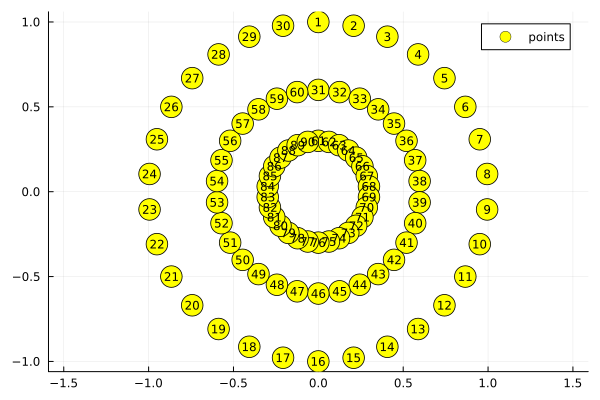

In [7]:
function noisy_circle(n; r1=1, r2=1, noise=0.1)
    points = zeros(2, n)
    for i in 1:n
        θ = 2π * (i-1)/n #rand()
        point = (
            r1 * sin(θ) + noise * rand() - noise / 2,
            r2 * cos(θ) + noise * rand() - noise / 2,
        )
        points[:,i] .= point
    end
    return points
end
points = hcat(noisy_circle(30, noise=0), 
              0.6 .* noisy_circle(30, noise=0),
              0.3 .* noisy_circle(30, noise=0))
scatter( points[1,:], points[2,:], aspect_ratio = 1, 
series_annotations = text.(1:size(points,2), :center, 8), ms = 12, mc = :yellow, label = "points")

(dim, n) = size(points) = (2, 90)


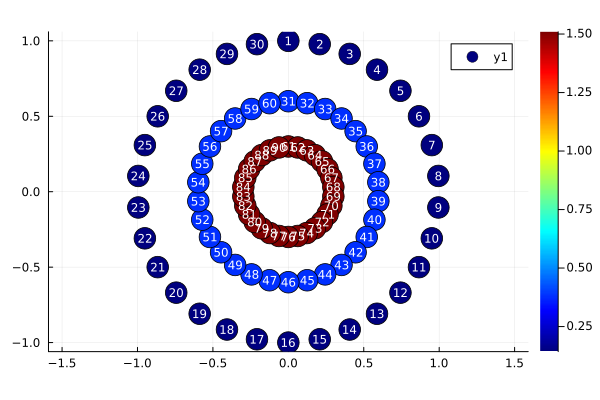

In [10]:
import ClusteringToMaTo: density_function

@show dim, n  = size(points)
kdtree = KDTree(points)
q = 4
idxs, dists = knn(kdtree, points, q)

f = density_function(dists, dim, q) # compute density function approximation using regularization parameter q
scatter( points[1,:], points[2,:], aspect_ratio = 1, 
         series_annotations = text.(1:size(points,2), :center, 8, :white), 
         ms = 12, marker_z = f, color = :jet)

In [31]:
"""
k : nearest neigbors if graph == 1
k : ball size if graph == 2
q : regularization parameter of f
τ : merging parameter
"""
function data2clust(points, graph, k, q, τ)

    @assert graph in (1,2) "The variable `graph` should be 1 or 2"

    dim, n  = size(points)
    kdtree = KDTree(points)
    idxs, dists = knn(kdtree, points, q)

    f = density_function(dists, dim, q) # density function approximation

    if graph == 1
        idxs, dists = knn(kdtree, points, k) # nearest neighbars
    elseif graph == 2
        idxs = inrange(kdtree, points, k) # ball of size k
    end

    v = sortperm(f, rev = true) # sort vertices using f
    f .= f[v] # sort f
    vertices_corr_inv = Dict(zip(v, 1:n)) #indexes of vertices in f
    G = [[vertices_corr_inv[i] for i in subset] for subset in idxs[v]]
    𝒰 = IntDisjointSets(n)
    for i = eachindex(v)
        𝒩 = [j for j in G[i] if j < i]
        if length(𝒩) == 0
            continue
        else
            g = 𝒩[argmax(view(f, 𝒩))] # approximate gradient at vertex i
            eᵢ = find_root!(𝒰, g) # r(eᵢ)
            union!(𝒰, eᵢ, i) # Attach vertex i to the entry eᵢ
            for j in 𝒩
                e = find_root!(𝒰, j) # r(e)
                if e != eᵢ && min(f[e], f[eᵢ]) <= f[i] + τ # merge
                    if f[e] < f[eᵢ]
                        union!(𝒰, eᵢ, e)
                    else
                        union!(𝒰, e, eᵢ)
                    end 
                    eᵢ = find_root!(𝒰, e)   
                end
            end
        end
    end
    # the collection of entries e of 𝒰 such that f(r(e)) ≥ τ
    s = Set{Int}([])
    for i = 1:n
        g = find_root!(𝒰, i) #  r(e)
        if f[g] >= τ 
           push!(s, g)
        end
    end
    labels = zeros(Int, n)
    for (c,j) in enumerate(s), i in 1:n
        if in_same_set(𝒰, j, i)
            labels[v[i]] = c
        end
    end

    return labels

end


data2clust

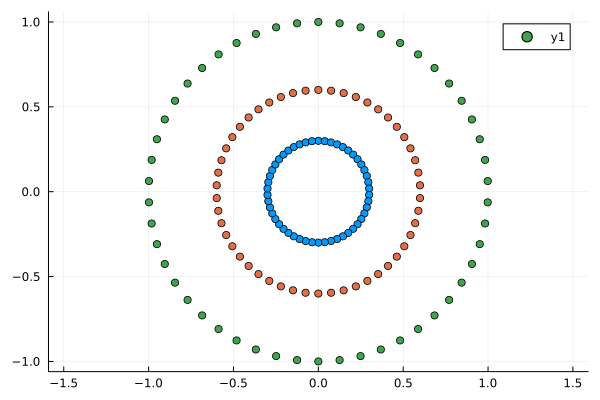

In [33]:
points = hcat(noisy_circle(50, noise=0), 
              0.6 .* noisy_circle(50, noise=0),
              0.3 .* noisy_circle(50, noise=0))

graph, k = 1, 4
q = 4
τ = 0.1

labels = data2clust(points, graph, k, q, τ)
scatter( points[1,:], points[2,:], c = labels, aspect_ratio = 1)